In [1]:
# model loader - BraTS

import os
import sys
import torch
sys.path.append("..")
sys.path.append("../brats-mri")
sys.path.append('../brats-mri/brats_mri_class_cond/')
import monai
from PIL import Image
from tqdm import tqdm
from monai.utils import first
from generative.inferers import LatentDiffusionInferer
from generative.networks.schedulers import DDIMScheduler

from torch.utils.data import DataLoader

from pretrained import load_autoencoder, load_unet
import utils
from scripts.utils import compute_scale_factor

BUNDLE = '../brats-mri/brats_mri_class_cond/'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sys.path.append(BUNDLE)
from scripts.inferer import LatentDiffusionInfererWithClassConditioning

def get_monai_autoencoder(bundle_target, training_args, weights_override_path):
    # load autoencoder
    autoencoder = load_autoencoder(bundle_target,
                                   override_model_cfg_json=training_args.config,
                                   override_weights_load_path=weights_override_path)    
    return autoencoder

def get_monai_unet(bundle_target, training_args, weights_override_path):
    unet = load_unet(bundle_target,
                     context_conditioning=training_args.conditioning == 'context',
                     override_model_cfg_json=training_args.config,
                     override_weights_load_path=weights_override_path,
                     use_conditioning=True)
    return unet
    
def get_monai_model_dict(bundle_target, autoencoder_weights_path, unet_weights_path, dataset):
    monai_dict = {}
    monai_dict['device'] = device
    training_args = torch.load(os.path.join(output_dir, training_name, 'training_args'))

    monai_dict['autoencoder'] = get_monai_autoencoder(bundle_target, training_args, autoencoder_weights_path)
    monai_dict['unet'] = get_monai_unet(bundle_target, training_args, unet_weights_path)
    
    # set scheduler
    config = utils.model_config(bundle_target, training_args.config)
#     monai_dict['scheduler'] = config.get_parsed_content('noise_scheduler')
    scheduler = DDIMScheduler(num_train_timesteps=1000,
                              beta_start=0.0015, beta_end=0.0195,
                              schedule='scaled_linear_beta', clip_sample=False)
    
    scale_factor = get_scale_factor(dataset, monai_dict['autoencoder'], device)
    # set inferer
    if training_args.conditioning in ['context', 'none']:
        monai_dict['inferer'] = LatentDiffusionInferer(scheduler=scheduler, scale_factor=scale_factor)
    else:
        monai_dict['inferer'] = LatentDiffusionInfererWithClassConditioning(scheduler=scheduler, scale_factor=scale_factor)
    return monai_dict

def get_scale_factor(dataset, autoencoder, device):
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
    scale_factor = compute_scale_factor(autoencoder, loader, device)
    return scale_factor

/opt/conda/envs/ldmonai/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/ldmonai/lib/python3.8/site-packages/monai/utils/tf32.py:66: UserWarning: torch.backends.cuda.matmul.allow_tf32 = True by default.
  This value defaults to True when PyTorch version in [1.7, 1.11] and may affect precision.
  See https://docs.monai.io/en/latest/precision_accelerating.html#precision-and-accelerating
  warnings.warn(


In [2]:
# confusion matrix plotter

from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def labels_to_human_labels(labels, human_labels_list):
    human_labels = [human_labels_list[int(x.detach().cpu().numpy())] for x in labels]  
    return human_labels

def plot_confusion_matrix(true_labels, labels_pred, human_labels_list):
    true_labels_readable = labels_to_human_labels(true_labels, human_labels_list)
    labels_pred_readable = labels_to_human_labels(labels_pred, human_labels_list)
    cm = confusion_matrix(true_labels_readable, labels_pred_readable, labels=human_labels_list)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=human_labels_list)
    fig, ax = plt.subplots(figsize=(12,12))
    disp.plot(ax=ax)
    plt.show()

ModuleNotFoundError: No module named 'sklearn'

In [2]:
import os
from enum import Enum
import pickle

sys.path.append("../diffusion_classifier")
from ldm_classifier_brats import MonaiLdmClassifier

def strip_epoch_num_from_ckpt(ckpt_full_path):
  ckpt_name = ckpt_full_path.split('/')[-1]  
  epoch_num = int(ckpt_name.split(".")[0].split("_")[-1])
  return epoch_num

def get_monai_training_ckpt_files(output_dir, training_name):
  ckpt_dir = os.path.join(output_dir, training_name)
  autoencoder_ckpt_files = [os.path.join(ckpt_dir, ckpt) for ckpt in os.listdir(ckpt_dir) if 'autoencoder' in ckpt]
  unet_ckpt_files = [os.path.join(ckpt_dir, ckpt) for ckpt in os.listdir(ckpt_dir) if 'diffusion' in ckpt]
  return autoencoder_ckpt_files, unet_ckpt_files


def evaulate_accuaracy_for_ckpt(autoenc_ckpt, unet_ckpt, dataset):
    # load model
    model_dict = get_monai_model_dict(BUNDLE, autoenc_ckpt, unet_ckpt, dataset)

    # instantiate ldm classifier
    ldm_clf = MonaiLdmClassifier(**model_dict)
    # run classification
    l2_labels_pred, l1_labels_pred, true_labels = ldm_clf.classify_dataset(dataset=ds,
                                                                           batch_size=1,
                                                                           n_trials=n_trials,
                                                                           t_sampling_stride=t_sampling_stride)
    # delete model
    del model_dict
    del ldm_clf
    return l2_labels_pred, l1_labels_pred, true_labels


def evaluate_accuracy_over_epochs(output_dir, 
                                  training_name, 
                                  dataset, 
                                  t_sampling_stride = 50,
                                  n_trials = 1
                                 ):
    # create classification results dir under the training dir
    clf_dir = os.path.join(output_dir, training_name, 'classification')
    if not os.path.exists(clf_dir):
        os.makedirs(clf_dir)
    n_pred_files = len(os.listdir(clf_dir))

    clf_res_per_epoch = {'dataset': dataset}
    # prepare files
    autencoder_ckpt_files, unet_ckpt_files = get_monai_training_ckpt_files(output_dir, training_name)
    # loop over ckpts
    for autoenc_ckpt, unet_ckpt in zip(autencoder_ckpt_files, unet_ckpt_files):
        epoch_num = strip_epoch_num_from_ckpt(autoenc_ckpt)
        
        l2_labels_pred, l1_labels_pred, true_labels = evaulate_accuaracy_for_ckpt(autoenc_ckpt, unet_ckpt, dataset)
        
        # save results
        clf_res_per_epoch[epoch_num] = {
          'true_labels': true_labels,
          'l1_pred_labels': l1_labels_pred,
          'l2_pred_labels': l2_labels_pred,
        }
        with open(os.path.join(clf_dir, f'predictions_{n_pred_files}'), 'wb') as f:
            pickle.dump(clf_res_per_epoch, f)
    
    return clf_res_per_epoch

In [3]:
import sys
# TODO - define the correct path to data
sys.path.append('../brats-mri/brats_mri_class_cond/scripts')
from ct_rsna import CTSubset
# from torchvision import transforms
import torch
from matplotlib import pyplot as plt
import numpy as np

In [4]:
# prepare data

np.random.seed(7)
torch.manual_seed(7)

train_dir = '../data/ct-rsna/train'
val_dir = '../data/ct-rsna/validation'

subset_len = 256
ds = CTSubset(data_dir=val_dir, labels_file='validation_set_dropped_nans.csv', size=256, flip_prob=0., subset_len=subset_len)

# LDM classifier params
t_sampling_stride = 50
n_trials = 5

# training dir
output_dir = '../data/outputs'
training_name = 'brats-2048-contd'

# # evaluate
# clf_res_per_epoch = evaluate_accuracy_over_epochs(output_dir, 
#                                                   training_name, 
#                                                   ds, 
#                                                   t_sampling_stride,
#                                                   n_trials)




Data source: validation_set_dropped_nans.csv
    Class none: 50.4%
    Class epidural: 7.0%
    Class intraparenchymal: 8.6%
    Class intraventricular: 13.7%
    Class subarachnoid: 9.4%
    Class subdural: 10.9%


In [5]:
import os
autoenc_ckpt = os.path.join(output_dir, training_name, 'autoencoder_epoch_440.ckpt')
unet_ckpt = os.path.join(output_dir, training_name, 'diffusion_epoch_440.ckpt')

model_dict = get_monai_model_dict(BUNDLE, autoenc_ckpt, unet_ckpt, ds)
unet = model_dict['unet']
autoencoder = model_dict['autoencoder']
inferer = model_dict['inferer']
unet.eval()
autoencoder.eval()

inferer.scheduler.set_timesteps(num_inference_steps=50)



Computing scale factor: 100%|█████████████████| 256/256 [00:13<00:00, 19.53it/s]

Scale factor: 0.83737


100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 24.71it/s]


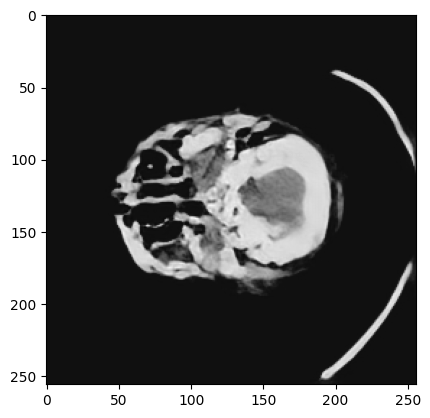

In [20]:
from matplotlib import pyplot as plt
n = 5
label = torch.full((1,), n, dtype=torch.long, device=device)

noise_shape = [1, 1, 64, 64]
noise = torch.randn(noise_shape, device=device)

im = inferer.sample(input_noise=noise,
                    save_intermediates=False,
                    intermediate_steps=200,
                    autoencoder_model=autoencoder,
                    diffusion_model=unet,
                    scheduler=inferer.scheduler,
                    class_labels=label) 
plt.imshow(im[0,0,:,:].detach().cpu().numpy().squeeze(), cmap='gray') 


In [15]:
autoenc_ckpt = os.path.join(output_dir, training_name, 'autoencoder_epoch_440.ckpt')
unet_ckpt = os.path.join(output_dir, training_name, 'diffusion_epoch_440.ckpt')
l2_labels_pred, l1_labels_pred, true_labels = evaulate_accuaracy_for_ckpt(autoenc_ckpt, unet_ckpt, ds)

from diffusion_classifier_interface import DiffusionClassifierInterface
l2_acc = DiffusionClassifierInterface.get_classification_accuracy(l2_labels_pred, 
                                                                  true_labels)
l1_acc = DiffusionClassifierInterface.get_classification_accuracy(l1_labels_pred, 
                                                                  true_labels)
print(f"l2_acc: {l2_acc}")
print(f"l1_acc: {l1_acc}")

FileNotFoundError: [Errno 2] No such file or directory: '../data/outputs/brats001/autoencoder_epoch_440.ckpt'

In [19]:
training_args = torch.load(os.path.join(output_dir, training_name, 'training_args'))
training_args

Namespace(batch_size=32, conditioning='context', config='inference_new.json', lr=0.0001, name='brats001', num_epochs=250, resume_from_ckpt=None, save_ckpt_every_n=250, seed=42, val_every_n_epochs=50)

In [17]:
from diffusion_classifier_interface import DiffusionClassifierInterface

l2_acc = DiffusionClassifierInterface.get_classification_accuracy(clf_res_per_epoch[250]['l2_pred_labels'], 
                                                                  clf_res_per_epoch[250]['true_labels'])
l1_acc = DiffusionClassifierInterface.get_classification_accuracy(clf_res_per_epoch[250]['l1_pred_labels'], 
                                                                  clf_res_per_epoch[250]['true_labels'])

print(f"L2 accuracy: {l2_acc}")
print(f"L1 accuracy: {l1_acc}")

L2 accuracy: 24.609375
L1 accuracy: 30.078125


In [9]:
loader = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=False)
batch = next(iter(loader))
# make sure batch is on device!
for k in batch.keys():
    try:
        batch[k] = batch[k].to(device)
    except:
        pass

autoenc_ckpt = '../data/outputs/brats001/autoencoder_epoch_250.ckpt'
unet_ckpt = '../data/outputs/brats001/diffusion_epoch_250.ckpt'
model_dict = get_monai_model_dict(BUNDLE, autoenc_ckpt, unet_ckpt, ds)

# instantiate ldm classifier
ldm_clf = MonaiLdmClassifier(**model_dict)
# run classification
c_hypotheses = ldm_clf.get_class_hypotheses_for_batch(batch_size=1, classes=[0])
ldm_clf.classify_batch(batch, c_hypotheses=c_hypotheses, t_sampling_stride=50)

Computing scale factor: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.86it/s]

Scale factor: 1.10544


class hypothsis:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1, 1, 256, 256])
torch.Size([20, 1, 64, 64])
{'class_label': tensor([0], device='cuda:0')}


RuntimeError: invalid argument 7: equal number of batches expected at /opt/conda/conda-bld/pytorch_1603729096996/work/aten/src/THC/generic/THCTensorMathBlas.cu:32